# Lab: Filtracja obrazów w dziedzinie częstotliwości
## 1. Wprowadzenie

Filtracja w dziedzinie częstotliwości polega na modyfikacji widma sygnału (obrazu) po wykonaniu dyskretnej transformaty Fouriera (DFT).
Obraz przestrzenny → widmo częstotliwościowe → filtracja → obraz po odwrotnej FFT.

## 2. Cele laboratorium

- Poznanie przekształcenia FFT obrazów.
- Zastosowanie filtrów w dziedzinie częstotliwości (LPF, HPF, BPF).
- Rekonstrukcja obrazu po filtracji.
- Analiza charakteru filtrów i ich efektu na obraz.

### Wczytanie obrazu i przygotowanie

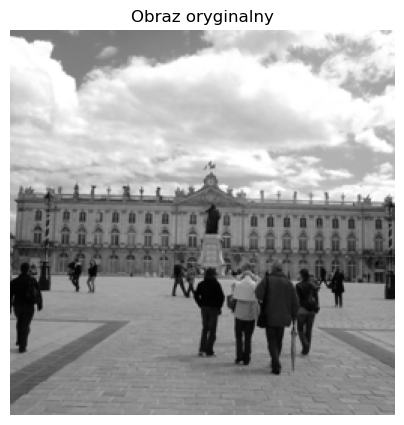

In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Wczytanie obrazu
img = cv2.imread("4s.png", cv2.IMREAD_GRAYSCALE).astype(np.float32)

plt.figure(figsize=(5,5))
plt.imshow(img, cmap='gray')
plt.title("Obraz oryginalny")
plt.axis("off")
plt.show()


### Filtr 1 — LPF (Low-Pass Filter)

LPF zachowuje niskie częstotliwości (gładkie zmiany), usuwa wysokie (szum, krawędzie).
Geometria: maska kołowa.

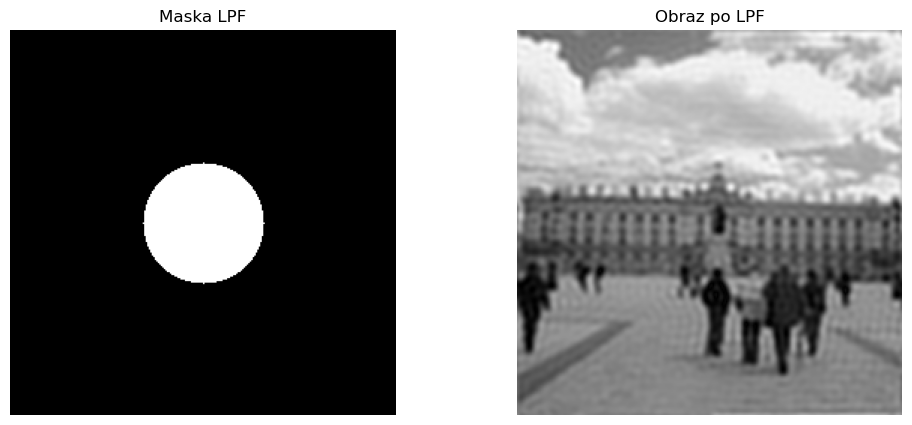

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# ---------------------------------------------------------
# Wczytanie obrazu (jeśli już masz img, pominąć)
# ---------------------------------------------------------
# img = np.array(Image.open("4.png").convert("L"), dtype=np.float32)

# ---------------------------------------------------------
# 1. FFT + przesunięcie widma
# ---------------------------------------------------------
fft = np.fft.fft2(img)
fft_shift = np.fft.fftshift(fft)

# ---------------------------------------------------------
# 2. Tworzenie maski LPF
# ---------------------------------------------------------
rows, cols = img.shape
crow, ccol = rows // 2, cols // 2

r = 40  # promień LPF
mask_lpf = np.zeros((rows, cols), np.uint8)

y, x = np.ogrid[:rows, :cols]
mask_lpf[(x - ccol)**2 + (y - crow)**2 <= r*r] = 1

# ---------------------------------------------------------
# 3. Filtracja w dziedzinie częstotliwości
# ---------------------------------------------------------
lpf_shift = fft_shift * mask_lpf
lpf_back = np.abs(np.fft.ifft2(np.fft.ifftshift(lpf_shift)))

# ---------------------------------------------------------
# 4. Wizualizacja
# ---------------------------------------------------------
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.imshow(mask_lpf, cmap="gray")
plt.title("Maska LPF")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(lpf_back, cmap="gray")
plt.title("Obraz po LPF")
plt.axis("off")

plt.show()


### Filtr 2 — HPF (High-Pass Filter)
HPF usuwa niskie częstotliwości, wzmacnia krawędzie i detale.

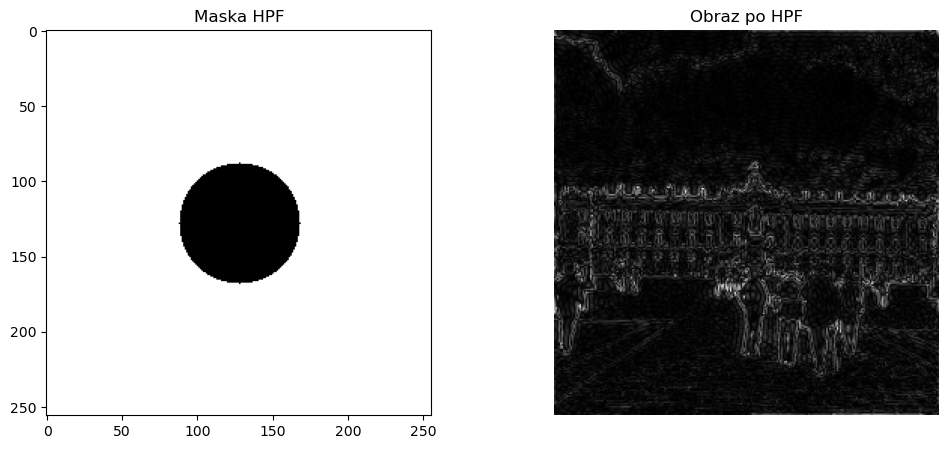

In [14]:
mask_hpf = 1 - mask_lpf

hpf_shift = fft_shift * mask_hpf
hpf_back = np.abs(np.fft.ifft2(np.fft.ifftshift(hpf_shift)))

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.imshow(mask_hpf, cmap="gray")
plt.title("Maska HPF")

plt.subplot(1,2,2)
plt.imshow(hpf_back, cmap="gray")
plt.title("Obraz po HPF")
plt.axis("off")

plt.show()


### Filtr 3 — BPF (Band-Pass Filter)

BPF przepuszcza tylko środkowy zakres częstotliwości.

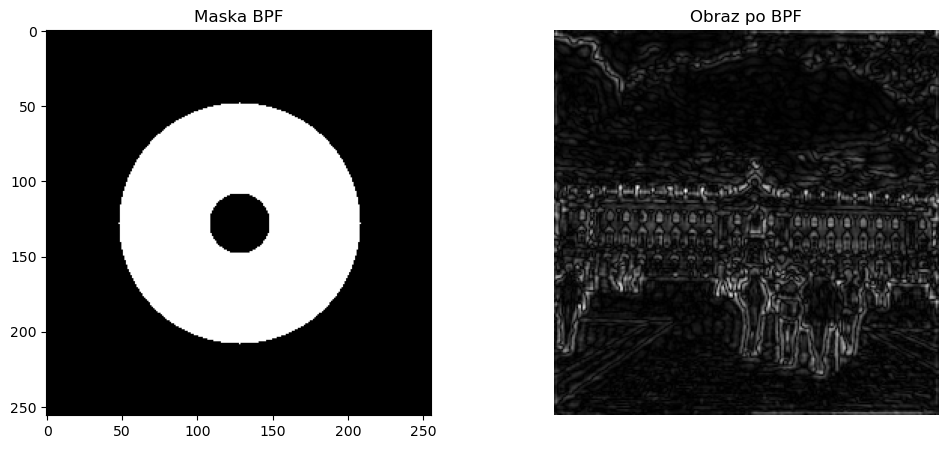

In [15]:
mask_bpf = np.zeros((rows, cols), np.uint8)
r1, r2 = 20, 80
mask_bpf[((x-ccol)**2 + (y-crow)**2 >= r1*r1) &
         ((x-ccol)**2 + (y-crow)**2 <= r2*r2)] = 1

bpf_shift = fft_shift * mask_bpf
bpf_back = np.abs(np.fft.ifft2(np.fft.ifftshift(bpf_shift)))

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.imshow(mask_bpf, cmap='gray')
plt.title("Maska BPF")

plt.subplot(1,2,2)
plt.imshow(bpf_back, cmap='gray')
plt.title("Obraz po BPF")
plt.axis("off")

plt.show()


### Porównanie filtrów

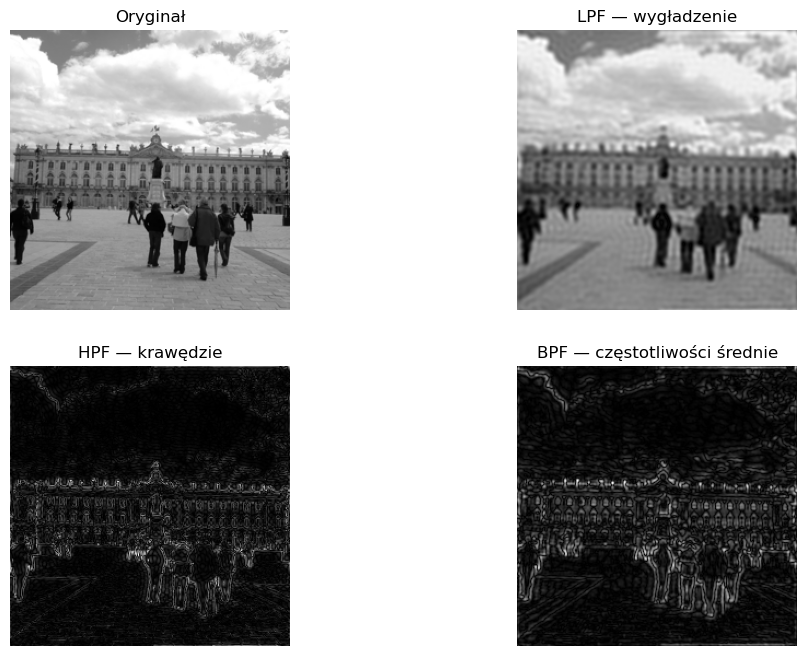

In [16]:
plt.figure(figsize=(12,8))

plt.subplot(2,2,1)
plt.imshow(img, cmap='gray')
plt.title("Oryginał")
plt.axis("off")

plt.subplot(2,2,2)
plt.imshow(lpf_back, cmap='gray')
plt.title("LPF — wygładzenie")
plt.axis("off")

plt.subplot(2,2,3)
plt.imshow(hpf_back, cmap='gray')
plt.title("HPF — krawędzie")
plt.axis("off")

plt.subplot(2,2,4)
plt.imshow(bpf_back, cmap='gray')
plt.title("BPF — częstotliwości średnie")
plt.axis("off")

plt.show()


### Analiza błędu rekonstrukcji

Porównujemy obraz przed i po filtracji, używając MSE i PSNR.

In [19]:
import numpy as np

def mse(a, b):
    return np.mean((a - b) ** 2)

def psnr(a, b):
    MSE = mse(a, b)
    if MSE == 0:
        return 999
    return 10 * np.log10((255 * 255) / MSE)

# --- MSE ---
mse_lpf = mse(img, lpf_back)
mse_hpf = mse(img, hpf_back)
mse_bpf = mse(img, bpf_back)

print("=== MSE ===")
print("LPF:", mse_lpf)
print("HPF:", mse_hpf)
print("BPF:", mse_bpf)

# --- PSNR ---
print("\n=== PSNR ===")
print("LPF:", psnr(img, lpf_back))
print("HPF:", psnr(img, hpf_back))
print("BPF:", psnr(img, bpf_back))


=== MSE ===
LPF: 123.29979
HPF: 26534.316
BPF: 25593.43

=== PSNR ===
LPF: 27.221182
HPF: 3.8927245
BPF: 4.0495186


### Histogramy błędów filtracji

Histogram błędu przedstawia rozkład wartości różnic pomiędzy obrazem oryginalnym a obrazem przefiltrowanym.  
Dla danego filtra definiuje się błąd jako:

$$
e(x,y) = I(x,y) - \hat{I}(x,y)
$$

gdzie:

- \(I(x,y)\) — obraz oryginalny,
- \(\hat{I}(x,y)\) — obraz po filtracji (LPF, HPF lub BPF).

Histogram obrazuje liczbę pikseli przyjmujących określoną wartość błędu \(e(x,y)\).  
Interpretacja rozkładu:

- koncentracja wartości wokół zera ⇒ filtr zachowuje większość informacji obrazu (mała degradacja);
- szeroki rozkład ⇒ filtr wprowadza znaczące zmiany (duże rekonstrukcyjne resztki);
- asymetria rozkładu ⇒ systematyczne przesunięcie wartości (np. tłumienie/wyostrzanie);
- ogony rozkładu ⇒ rzadkie, lecz silne lokalne zaburzenia (hotspoty / artefakty).

Dla czytelnej analizy wykresów zaleca się porównanie histogramów kilku filtrów w tej samej skali osi (także ograniczenie zakresu wartości błędu).


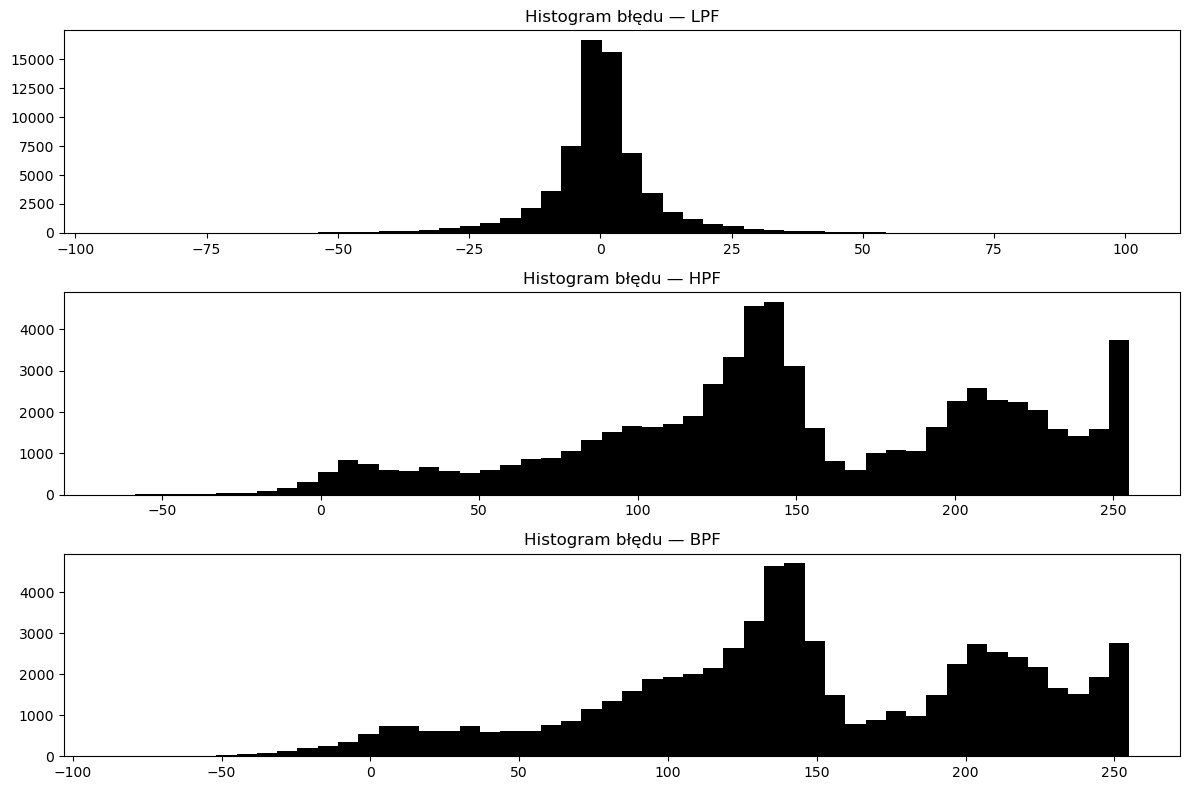

In [18]:
errors = {
    "LPF": img - lpf_back,
    "HPF": img - hpf_back,
    "BPF": img - bpf_back,
}

plt.figure(figsize=(12,8))

for i, (name, err) in enumerate(errors.items()):
    plt.subplot(3,1,i+1)
    plt.hist(err.flatten(), bins=50, color='k')
    plt.title(f"Histogram błędu — {name}")

plt.tight_layout()
plt.show()


### Zadanie do wykonania:

1. Zastosować filtrację w dziedzinie częstotliwości 
   Dla obrazów należących do czterech klas należy zastosować następujące typy filtrów:
    - filtr dolnoprzepustowy (LPF),
    - filtr górnoprzepustowy (HPF),
    - filtr pasmowoprzepustowy (BPF).

2. Przeprowadzić rekonstrukcję obrazów po filtracji
   Odtworzyć sygnał obrazowy poprzez wykonanie odwrotnej transformacji Fouriera.

3. Wyznaczyć miary jakości rekonstrukcji
   Dla każdego obrazu i każdego filtru obliczyć:
    - błąd średniokwadratowy (MSE),
    - stosunek sygnału do szumu szczytowego (PSNR).

3. Przeanalizować rozkład błędów rekonstrukcji
   Wygenerować histogramy błędów pikselowych dla każdej konfiguracji filtr–obraz.

4. Sformułować wnioski
    W analizie uwzględnić charakterystykę zastosowanych filtrów oraz ich wpływ na:
    - zachowanie składowych częstotliwościowych,
    - poziom zniekształceń rekonstrukcji,
    - strukturę błędów.

### Pytania kontrolne

1. Co oznacza domena częstotliwościowa obrazu?
2. Dlaczego w analizie używamy przesunięcia widma (fftshift)?
3. Co reprezentuje widmo amplitudowe, a co fazowe?
4. Jak działa filtr dolnoprzepustowy w domenie FFT?
5. Dlaczego LPF wygładza obraz?
6. Jakie informacje usuwa HPF?
7. Do czego służy filtr pasmowoprzepustowy (BPF)?
8. Jak interpretować błąd rekonstrukcji po filtracji?
9. Jakie artefakty mogą powstać przy ostrych maskach częstotliwości?
10. Jaką rolę pełni PSNR w ocenie filtracji częstotliwościowej?